# **Heterogeneous GraphSAGE — Script 2: Training, Hyperparameter Search, and Evaluation**

This notebook assumes that **Script 1 (`hetero_graphsage_build_graph.py`)** has already produced
`graph_15features_scaled_balanced.pt`, which contains:

* balanced train/validation/test edge masks,
* engineered edge features,
* projected user and merchant node features,
  stored as a **PyG `HeteroData` object**.

### **Requirements**

1. Load the processed heterogeneous graph dataset
   **`graph_15features_scaled_balanced.pt`**.
2. Ensure that **`best_search_model.pt`** and **`search_summary.json`** are saved,
   as these will be used by the downstream ensemble notebook
   **`graphsage_lgbm_ensemble.ipynb`**.


# Importing library

In [1]:
# !pip install torch_geometric pyg_lib torch_scatter torch_sparse torch_cluster -f https://data.pyg.org/whl/torch-$(python -c 'import torch; print(torch.__version__)').html

Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.1 MB/s eta 0:00:00


In [ ]:
import os
import ast
import json
import time
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve, CalibrationDisplay

from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import HeteroConv, SAGEConv
import torch_geometric.transforms as T

# comment out if not running on google colab
# from google.colab import drive
# drive.mount("/content/drive")

DATA_DIR = "../../../Data/gnn/"

# Randomised Hyperparameter Search


In [3]:
DATA_PATH  = os.path.join(DATA_DIR, "graph_15features_scaled_balanced.pt")
BATCH_SIZE = 2048
NUM_WORKERS = 0

SEARCH_DIR = "/runs"  # to save outputs
os.makedirs(SEARCH_DIR, exist_ok=True)

# Reproducibility
def set_seed(seed: int, deterministic_cudnn: bool = False, cudnn_benchmark: bool = True):
    import numpy as _np, random as _random, torch as _torch
    _random.seed(seed); _np.random.seed(seed)
    _torch.manual_seed(seed)
    if _torch.cuda.is_available():
        _torch.cuda.manual_seed_all(seed)
    _torch.backends.cudnn.benchmark = cudnn_benchmark
    _torch.backends.cudnn.deterministic = deterministic_cudnn

GLOBAL_SEED = 42
# For hyperparameter tuning: allow some non-determinism (deterministic_cudnn=False)
# and enable cudnn_benchmark=True for faster convolutions
set_seed(GLOBAL_SEED, deterministic_cudnn=False, cudnn_benchmark=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Metric focus
FOCUS_METRIC = "pr"   # "roc" or "pr"

def pick_metric(roc, pr):
    return roc if FOCUS_METRIC == "roc" else pr

# Model
class EdgeAwareHeteroSAGE(nn.Module):
    def __init__(self, metadata, in_channels, hidden_channels, out_channels, edge_feature_dim,
                 dropout_p=0.3, aggr_rel='mean', aggr_sage='mean'):
        """
        2-layer heterogeneous GraphSAGE encoder with an edge-aware decoder.

        - Encoder: two HeteroConv(SAGEConv) layers over all edge types defined in
          `metadata`, with configurable aggregation across relations and neighbours.
        - Decoder: combines source (user) and destination (merchant) embeddings with:
            * projected edge features,
            * element-wise interactions (u*m),
            * edge-gated embeddings (u*gate, m*gate),
          and feeds the concatenation into a small linear classifier to predict
          fraud probability at the edge level.
        """
        super().__init__()
        self.dropout_p = dropout_p

        # Encoder
        # Hetero GraphSAGE layers
        self.conv1 = HeteroConv(
            {et: SAGEConv((-1, -1), hidden_channels, aggr=aggr_sage) for et in metadata[1]},
            aggr=aggr_rel
        )
        self.conv2 = HeteroConv(
            {et: SAGEConv((-1, -1), out_channels, aggr=aggr_sage) for et in metadata[1]},
            aggr=aggr_rel
        )

        # Edge-Aware Decoder
        # 1. MLP to project edge features to the same dimension as node embeddings
        hidden_mlp_width = max(32, edge_feature_dim)
        self.edge_proj = nn.Sequential(
            nn.Linear(edge_feature_dim, hidden_mlp_width),
            nn.ReLU(),
            nn.Linear(hidden_mlp_width, out_channels),   # project to out_channels
            nn.Dropout(self.dropout_p),
        )

        # 2. MLP to create a "gate" vector from edge features
        self.edge_gate = nn.Sequential(
            nn.Linear(edge_feature_dim, out_channels),
            nn.Sigmoid()
        )

        # 3. Final classifier
        # u, m, (u*m), e_h, (u*gate), (m*gate)
        self.classifier = nn.Linear(6 * out_channels, 1)

    def encode(self, x_dict, edge_index_dict):
        """Generates node embeddings using the 2-layer GNN encoder."""
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}
        x_dict = {k: F.dropout(v, p=self.dropout_p, training=self.training) for k, v in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        return x_dict

    def decode(self, x_dict, edge_label_index, edge_attr):
        """Predicts edge labels using the edge-aware decoder."""
        src, dst = edge_label_index
        u = x_dict['user'][src] # Source node (user) embeddings [B, out_channels]
        m = x_dict['merchant'][dst] # Dest node (merchant) embeddings [B, out_channels]

        e_h   = self.edge_proj(edge_attr) # Projected edge features [B, out_channels]
        gate  = self.edge_gate(edge_attr) # Gating vector [B, out_channels]

        um    = u * m # Element-wise interaction
        ug    = u * gate # Gated user embedding
        mg    = m * gate # Gated merchant embedding

        z = torch.cat([u, m, um, e_h, ug, mg], dim=-1)  # [B, 6*out_channels]
        return self.classifier(z).squeeze(-1)

    def forward(self, x_dict, edge_index_dict, edge_label_index, edge_attr):
        """Full model pass: encode nodes, then decode edges."""
        x_dict = self.encode(x_dict, edge_index_dict)
        return self.decode(x_dict, edge_label_index, edge_attr)


# Train / Eval
def train_one_epoch(loader, model, optimizer, criterion, data_cpu, device, clip_norm=1.0):
    """
    One training epoch over edge-level mini-batches.

    For each batch:
    - reconstruct the corresponding edge attributes from the full CPU graph
      using `e.input_id`,
    - run the model forward pass,
    - compute the (focal) loss against the edge labels,
    - backpropagate with gradient clipping.

    Returns the average loss per edge for logging.
    """
    model.train()
    total_loss, total_n = 0.0, 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad(set_to_none=True)
        e = batch['user','transaction','merchant']
        idx = e.input_id.cpu()
        edge_attr = data_cpu['user','transaction','merchant'].edge_attr[idx].to(device)
        logits = model(batch.x_dict, batch.edge_index_dict, e.edge_label_index, edge_attr)
        loss = criterion(logits, e.edge_label)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
        optimizer.step()
        total_loss += loss.item() * logits.numel()
        total_n += logits.numel()
    return total_loss / max(total_n, 1)

@torch.no_grad()
def evaluate(loader, model, data_cpu, device):
    """
    Evaluate the model on a given edge split (e.g., validation or test).

    Returns:
    - ROC-AUC and PR-AUC scores.
    """
    model.eval()
    probs, labels = [], []
    for batch in loader:
        batch = batch.to(device)
        e = batch['user','transaction','merchant']
        idx = e.input_id.cpu()
        edge_attr = data_cpu['user','transaction','merchant'].edge_attr[idx].to(device)
        logits = model(batch.x_dict, batch.edge_index_dict, e.edge_label_index, edge_attr)
        probs.append(torch.sigmoid(logits).cpu()); labels.append(e.edge_label.cpu())
    p = torch.cat(probs).numpy(); y = torch.cat(labels).numpy()
    if len(np.unique(y)) < 2:
        return 0.5, 0.5
    return roc_auc_score(y, p), average_precision_score(y, p)

# Data loading
print(f"Using device: {device}")
print(f"Loading {DATA_PATH} ...")
data = torch.load(DATA_PATH, map_location='cpu', weights_only=False)
data = T.ToUndirected()(data)

data_cpu = data.to('cpu')
data['user'].x     = data['user'].x.to(device)
data['merchant'].x = data['merchant'].x.to(device)

METADATA  = data.metadata()
EDGE_TYPE = ('user','transaction','merchant')
EDGE_DATA = data_cpu[EDGE_TYPE]
EDGE_CH   = EDGE_DATA.edge_attr.shape[1]
IN_CH     = data_cpu['user'].x.shape[1]

# Precompute split tensors for loaders and pos_weight
edge_index_train = EDGE_DATA.edge_index[:, EDGE_DATA.train_mask]
edge_index_val   = EDGE_DATA.edge_index[:, EDGE_DATA.val_mask]
edge_label_train = EDGE_DATA.edge_label[EDGE_DATA.train_mask]
edge_label_val   = EDGE_DATA.edge_label[EDGE_DATA.val_mask]

def get_pos_weight(y: torch.Tensor, device):
    y = y.float()
    pos = y.sum()
    neg = y.numel() - pos
    w = (neg / pos).clamp(min=1.0) if pos > 0 else torch.tensor(1.0)
    return torch.tensor([float(w)], device=device)

pos_w = get_pos_weight(edge_label_train, device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_w)
print(f"pos_weight computed from train split: {pos_w.item():.4f}")

# Search Space
SEARCH_SPACE = {
    'lr': [3e-4, 5e-4, 1e-3, 2e-3],
    'hidden_channels': [128, 256],
    'out_channels': [64, 128, 256],
    'num_neighbors': [[25,10], [15,10], [10,10]],
    'dropout_p': [0.2, 0.3, 0.5],
    'weight_decay': [0.0, 1e-5, 1e-4, 1e-3],
    'aggr_rel': ['mean', 'sum'],  # HeteroConv aggregation across edge types
    'aggr_sage': ['mean', 'sum'], # SAGEConv aggregation for neighbors
}

N_TRIALS = 10
EPOCHS_PER_TRIAL = 15

# Logging Setup
trials_csv = os.path.join(SEARCH_DIR, "search_trials.csv")
with open(trials_csv, "w") as f:
    f.write("trial,epoch,lr,hidden_channels,out_channels,num_neighbors,dropout_p,weight_decay,"
            "aggr_rel,aggr_sage,train_loss,val_roc,val_pr,seed,timestamp\n")

best_score = -1.0
best_params = None
best_meta = {}

keys = list(SEARCH_SPACE.keys())
values = list(SEARCH_SPACE.values())
candidates = [dict(zip(keys, [random.choice(v) for v in values])) for _ in range(N_TRIALS)]
# Randomly sample N_TRIALS configurations from the discrete search space

print("\n--- Starting Randomised Hyperparameter Search ---")
for t, params in enumerate(candidates, 1):
    model = EdgeAwareHeteroSAGE(
        METADATA,
        in_channels=IN_CH,
        hidden_channels=params['hidden_channels'],
        out_channels=params['out_channels'],
        edge_feature_dim=EDGE_CH,
        dropout_p=params['dropout_p'],
        aggr_rel=params['aggr_rel'],
        aggr_sage=params['aggr_sage'],
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    train_loader = LinkNeighborLoader(
        data_cpu, num_neighbors=params['num_neighbors'], batch_size=BATCH_SIZE,
        edge_label_index=(EDGE_TYPE, edge_index_train), edge_label=edge_label_train,
        shuffle=True, num_workers=NUM_WORKERS
    )
    val_loader = LinkNeighborLoader(
        data_cpu, num_neighbors=params['num_neighbors'], batch_size=BATCH_SIZE,
        edge_label_index=(EDGE_TYPE, edge_index_val), edge_label=edge_label_val,
        shuffle=False, num_workers=NUM_WORKERS
    )

    trial_best = -1.0
    print(f"\nTrial {t}/{N_TRIALS} | Params: {params}")
    for epoch in range(1, EPOCHS_PER_TRIAL + 1):
        train_loss = train_one_epoch(train_loader, model, optimizer, criterion, data_cpu, device, clip_norm=1.0)
        val_roc, val_pr = evaluate(val_loader, model, data_cpu, device)
        score = pick_metric(val_roc, val_pr)

        # Append a row per epoch
        with open(trials_csv, "a") as f:
            f.write(f"{t},{epoch},{params['lr']},{params['hidden_channels']},{params['out_channels']},"
                    f"\"{params['num_neighbors']}\",{params['dropout_p']},{params['weight_decay']},"
                    f"{params['aggr_rel']},{params['aggr_sage']},{train_loss:.6f},{val_roc:.6f},{val_pr:.6f},"
                    f"{GLOBAL_SEED},{int(time.time())}\n")

        if epoch % 5 == 0 or epoch == 1 or epoch == EPOCHS_PER_TRIAL:
            print(f"  Epoch {epoch:02d} | Loss {train_loss:.4f} | Val ROC-AUC {val_roc:.4f} | Val PR-AUC {val_pr:.4f}")

        if score > trial_best:
            trial_best = score
            if score > best_score:
                best_score = score
                best_params = dict(params)
                torch.save(model.state_dict(), os.path.join(SEARCH_DIR, "best_search_model.pt"))
                best_meta = {
                    "focus_metric": FOCUS_METRIC,
                    "best_val_focus": round(float(score), 6),
                    "best_val_roc_auc": round(float(val_roc), 6),
                    "best_val_pr_auc": round(float(val_pr), 6),
                    "params": best_params,
                    "seed": GLOBAL_SEED,
                    "timestamp": int(time.time()),
                    "data_path": DATA_PATH,
                    "batch_size": BATCH_SIZE,
                    "num_workers": NUM_WORKERS,
                }
                with open(os.path.join(SEARCH_DIR, "best_search_meta.json"), "w") as f:
                    json.dump(best_meta, f, indent=2)

    print(f"Trial {t} best {FOCUS_METRIC.upper()}: {trial_best:.4f}")

# Persist best params & summary
with open(os.path.join(SEARCH_DIR, "best_hyperparameters.txt"), "w") as f:
    f.write(str(best_params if best_params is not None else {}))

summary = {
    "focus_metric": FOCUS_METRIC,
    "search_space": SEARCH_SPACE,
    "n_trials": N_TRIALS,
    "epochs_per_trial": EPOCHS_PER_TRIAL,
    "seed": GLOBAL_SEED,
    "best": best_meta,
}
with open(os.path.join(SEARCH_DIR, "search_summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("\n--- Search Complete ---")
print(f"Best {FOCUS_METRIC.upper()}: {best_score:.4f}")
print(f"Best Params: {best_params}")

Using device: cuda
Loading /content/drive/MyDrive/graph_15features_scaled_balanced.pt ...
pos_weight computed from train split: 8.7164

--- Starting Randomised Hyperparameter Search ---

Trial 1/10 | Params: {'lr': 0.0003, 'hidden_channels': 128, 'out_channels': 256, 'num_neighbors': [15, 10], 'dropout_p': 0.2, 'weight_decay': 1e-05, 'aggr_rel': 'mean', 'aggr_sage': 'mean'}
  Epoch 01 | Loss 1.2427 | Val ROC-AUC 0.6405 | Val PR-AUC 0.1943
  Epoch 05 | Loss 0.9945 | Val ROC-AUC 0.8130 | Val PR-AUC 0.3336
  Epoch 10 | Loss 0.8338 | Val ROC-AUC 0.8577 | Val PR-AUC 0.4488
  Epoch 15 | Loss 0.7784 | Val ROC-AUC 0.8716 | Val PR-AUC 0.4864
Trial 1 best PR: 0.4864

Trial 2/10 | Params: {'lr': 0.0003, 'hidden_channels': 256, 'out_channels': 64, 'num_neighbors': [25, 10], 'dropout_p': 0.2, 'weight_decay': 1e-05, 'aggr_rel': 'mean', 'aggr_sage': 'mean'}
  Epoch 01 | Loss 1.2422 | Val ROC-AUC 0.7312 | Val PR-AUC 0.2446
  Epoch 05 | Loss 1.0190 | Val ROC-AUC 0.8039 | Val PR-AUC 0.3220
  Epoch 10 | 

# Final GNN Training


In [4]:
DATA_PATH  = os.path.join(DATA_DIR, "graph_15features_scaled_balanced.pt")
BATCH_SIZE = 2048
NUM_EPOCHS = 100
NUM_WORKERS = 0

OUT_DIR = "/runs"
os.makedirs(OUT_DIR, exist_ok=True)

# Reproducibility
def set_seed(seed: int, deterministic_cudnn: bool = True, cudnn_benchmark: bool = False):
    import numpy as _np, random as _random, torch as _torch
    _random.seed(seed); _np.random.seed(seed)
    _torch.manual_seed(seed)
    if _torch.cuda.is_available():
        _torch.cuda.manual_seed_all(seed)
    _torch.backends.cudnn.benchmark = cudnn_benchmark
    _torch.backends.cudnn.deterministic = deterministic_cudnn

GLOBAL_SEED = 42
# Reproducibility: fully deterministic training (no cuDNN autotune)
set_seed(GLOBAL_SEED, deterministic_cudnn=True, cudnn_benchmark=False)

# Metric focus
FOCUS_METRIC   = "pr" # "roc" or "pr"
THRESHOLD_MODE = "f1" # "youden" (ROC) or "f1" (PR)

def pick_focus(roc, pr):
    return roc if FOCUS_METRIC == "roc" else pr

def pick_threshold(val_y, val_p, mode="youden"):
    """
    Finds the best classification threshold from validation predictions.

    mode:
    - "f1":     maximises the F1-score (recommended for imbalanced data).
    - "youden": maximises Youden's J statistic (TPR − FPR) from the ROC curve.
    """
    if mode == "f1":
        prec, rec, thr = precision_recall_curve(val_y, val_p)
        thr_full = np.append(thr, 1.0)
        f1s = (2 * prec * rec) / np.clip(prec + rec, 1e-12, None)
        i = int(np.nanargmax(f1s))
        return float(thr_full[i]), float(f1s[i])
    else:  # Youden's J
        fpr, tpr, thr = roc_curve(val_y, val_p)
        j = tpr - fpr
        i = int(np.argmax(j))
        return float(thr[i]), float(j[i])

# Model
class EdgeAwareHeteroSAGE(nn.Module):
    def __init__(self, metadata, in_channels, hidden_channels, out_channels, edge_feature_dim,
                 dropout_p=0.3, aggr_rel='mean', aggr_sage='mean'):
        """
        2-layer heterogeneous GraphSAGE encoder with an edge-aware decoder.

        - Encoder: two HeteroConv(SAGEConv) layers over all edge types in
          `metadata`, with configurable aggregation across relations and neighbours.
        - Decoder: combines source (user) and destination (merchant) embeddings with:
            * projected edge features,
            * element-wise interactions (u*m),
            * edge-gated embeddings (u*gate, m*gate),
          and feeds the concatenation into a small linear classifier to predict
          fraud probability at the edge level.
        """
        super().__init__()
        self.dropout_p = dropout_p

        # Encoder
        # Hetero GraphSAGE layers
        self.conv1 = HeteroConv(
            {et: SAGEConv((-1, -1), hidden_channels, aggr=aggr_sage) for et in metadata[1]},
            aggr=aggr_rel
        )
        self.conv2 = HeteroConv(
            {et: SAGEConv((-1, -1), out_channels, aggr=aggr_sage) for et in metadata[1]},
            aggr=aggr_rel
        )

        # Edge-Aware Decoder
        # 1. MLP to project edge features to the same dimension as node embeddings
        hidden_mlp_width = max(32, edge_feature_dim)
        self.edge_proj = nn.Sequential(
            nn.Linear(edge_feature_dim, hidden_mlp_width),
            nn.ReLU(),
            nn.Linear(hidden_mlp_width, out_channels),   # project to out_channels
            nn.Dropout(self.dropout_p),
        )

        # 2. MLP to create a "gate" vector from edge features
        self.edge_gate = nn.Sequential(
            nn.Linear(edge_feature_dim, out_channels),
            nn.Sigmoid()
        )

        # 3. Final classifier
        # u, m, (u*m), e_h, (u*gate), (m*gate)
        self.classifier = nn.Linear(6 * out_channels, 1)

    def encode(self, x_dict, edge_index_dict):
        """Generates node embeddings using the 2-layer GNN encoder."""
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}
        x_dict = {k: F.dropout(v, p=self.dropout_p, training=self.training) for k, v in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        return x_dict

    def decode(self, x_dict, edge_label_index, edge_attr):
        """Predicts edge labels using the edge-aware decoder."""
        src, dst = edge_label_index
        u = x_dict['user'][src] # Source node (user) embeddings [B, out_channels]
        m = x_dict['merchant'][dst] # Dest node (merchant) embeddings [B, out_channels]

        e_h   = self.edge_proj(edge_attr) # Projected edge features [B, out_channels]
        gate  = self.edge_gate(edge_attr) # Gating vector [B, out_channels]

        um    = u * m # Element-wise interaction
        ug    = u * gate # Gated user embedding
        mg    = m * gate # Gated merchant embedding

        z = torch.cat([u, m, um, e_h, ug, mg], dim=-1)  # [B, 6*out_channels]
        return self.classifier(z).squeeze(-1)

    def forward(self, x_dict, edge_index_dict, edge_label_index, edge_attr):
        """Full model pass: encode nodes, then decode edges."""
        x_dict = self.encode(x_dict, edge_index_dict)
        return self.decode(x_dict, edge_label_index, edge_attr)

# Train / Eval
def train_one_epoch(loader, model, optimizer, criterion, data_cpu, device, clip_norm=1.0):
    model.train()
    total_loss, total_n = 0.0, 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad(set_to_none=True)
        e = batch['user','transaction','merchant']
        idx = e.input_id.cpu() # map mini-batch edges back to their positions in the full edge_attr tensor
        edge_attr = data_cpu['user','transaction','merchant'].edge_attr[idx].to(device)
        logits = model(batch.x_dict, batch.edge_index_dict, e.edge_label_index, edge_attr)
        loss = criterion(logits, e.edge_label)
        loss.backward()
        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
        optimizer.step()
        total_loss += loss.item() * logits.numel()
        total_n += logits.numel()
    return total_loss / max(total_n, 1)

@torch.inference_mode()
def evaluate(loader, model, data_cpu, device):
    model.eval()
    probs, labels = [], []
    for batch in loader:
        batch = batch.to(device)
        e = batch['user','transaction','merchant']
        idx = e.input_id.cpu()
        edge_attr = data_cpu['user','transaction','merchant'].edge_attr[idx].to(device)
        logits = model(batch.x_dict, batch.edge_index_dict, e.edge_label_index, edge_attr)
        probs.append(torch.sigmoid(logits).cpu()); labels.append(e.edge_label.cpu())
    p = torch.cat(probs).numpy(); y = torch.cat(labels).numpy()
    if len(np.unique(y)) < 2:
        return 0.5, 0.5, (np.array([0,1]), np.array([1,1]), np.array([0.5])), (np.array([0,1]), np.array([0,1]), np.array([0.5]))
    roc = roc_auc_score(y, p) if len(np.unique(y)) == 2 else 0.5
    pr  = average_precision_score(y, p) if len(np.unique(y)) == 2 else 0.5
    prec, rec, thr_pr = precision_recall_curve(y, p)
    fpr, tpr, thr_roc = roc_curve(y, p)
    return roc, pr, (prec, rec, thr_pr), (fpr, tpr, thr_roc), (y, p)

def pick_best_threshold(y, p):
    prec, rec, thr = precision_recall_curve(y, p)
    # thresholds returned are length-1 of prec/rec
    # align:
    thr_full = np.append(thr, 1.0)
    f1s = (2 * prec * rec) / np.clip(prec + rec, 1e-12, None)
    best_idx = int(np.nanargmax(f1s))
    return float(thr_full[best_idx]), float(f1s[best_idx])

#  Data Load
print(f"Using device: {device}")
print(f"Loading {DATA_PATH} ...")
data = torch.load(DATA_PATH, map_location='cpu', weights_only=False)
data = T.ToUndirected()(data)

data_cpu = data.to('cpu')
data['user'].x     = data['user'].x.to(device)
data['merchant'].x = data['merchant'].x.to(device)

METADATA  = data.metadata()
EDGE_TYPE = ('user','transaction','merchant')
EDGE_DATA = data_cpu[EDGE_TYPE]

# Precompute split indices/labels for convenience
edge_index_train = EDGE_DATA.edge_index[:, EDGE_DATA.train_mask]
edge_index_val   = EDGE_DATA.edge_index[:, EDGE_DATA.val_mask]
edge_index_test  = EDGE_DATA.edge_index[:, EDGE_DATA.test_mask]

edge_label_train = EDGE_DATA.edge_label[EDGE_DATA.train_mask]
edge_label_val   = EDGE_DATA.edge_label[EDGE_DATA.val_mask]
edge_label_test  = EDGE_DATA.edge_label[EDGE_DATA.test_mask]

def get_pos_weight(y: torch.Tensor, device):
    """Compute BCE `pos_weight` = (negatives / positives) for class-imbalance handling."""
    # y: 0/1 tensor
    y = y.float()
    pos = y.sum()
    neg = y.numel() - pos
    w = (neg / pos).clamp(min=1.0) if pos > 0 else torch.tensor(1.0)
    return torch.tensor([float(w)], device=device)

class BCEFocalLoss(nn.Module):
    """
    Binary Focal Loss with optional class `pos_weight`.

    This wraps `binary_cross_entropy_with_logits` to:
    - retain its numerical stability,
    - apply the standard focal modulating factor ( (1-p_t)^gamma ),
    making the model focus more on hard / misclassified examples, which
    is useful under heavy class imbalance.
    """
    def __init__(self, gamma=2.0, pos_weight=None, reduction="mean"):
        super().__init__()
        self.gamma = gamma
        self.pos_weight = pos_weight
        self.reduction = reduction

    def forward(self, logits, targets):
        # Calculate BCE loss without reduction
        bce = F.binary_cross_entropy_with_logits(
            logits, targets, pos_weight=self.pos_weight, reduction='none'
        )
        # Calculate probability of true class
        p = torch.sigmoid(logits)
        pt = targets * p + (1 - targets) * (1 - p)
        # Calculate focal loss: (1 - p_t)^gamma * BCE
        focal = (1 - pt).pow(self.gamma) * bce
        # Apply reduction
        if self.reduction == "mean":
            return focal.mean()
        if self.reduction == "sum":
            return focal.sum()
        return focal

EDGE_CH   = EDGE_DATA.edge_attr.shape[1]
IN_CH     = data_cpu['user'].x.shape[1]

# Load best hyperparameters from search
try:
    with open(os.path.join(OUT_DIR, "best_hyperparameters.txt"), "r") as f:
        best_hparams = ast.literal_eval(f.read())
    print(f"Loaded best params: {best_hparams}")
except Exception as e:
    print(f"Could not load best_hyperparameters.txt ({e}). Using defaults.")
    best_hparams = {'lr': 1e-3, 'hidden_channels': 256, 'out_channels': 128, 'num_neighbors': [15, 10]}


pos_w = get_pos_weight(edge_label_train, device)
criterion = BCEFocalLoss(gamma=2.0, pos_weight=pos_w)
print(f"pos_weight computed from train split: {pos_w.item():.4f}")

# Loaders
train_loader = LinkNeighborLoader(
    data_cpu, num_neighbors=best_hparams.get('num_neighbors', [15,10]), batch_size=BATCH_SIZE,
    edge_label_index=(EDGE_TYPE, edge_index_train),
    edge_label=edge_label_train, shuffle=True, num_workers=NUM_WORKERS
)
val_loader = LinkNeighborLoader(
    data_cpu, num_neighbors=best_hparams.get('num_neighbors', [15,10]), batch_size=BATCH_SIZE,
    edge_label_index=(EDGE_TYPE, edge_index_val),
    edge_label=edge_label_val, shuffle=False, num_workers=NUM_WORKERS
)
test_loader = LinkNeighborLoader(
    data_cpu, num_neighbors=best_hparams.get('num_neighbors', [15,10]), batch_size=BATCH_SIZE,
    edge_label_index=(EDGE_TYPE, edge_index_test),
    edge_label=edge_label_test, shuffle=False, num_workers=NUM_WORKERS
)

# Model
model = EdgeAwareHeteroSAGE(
    METADATA,
    in_channels=IN_CH,
    hidden_channels=best_hparams.get('hidden_channels', 256),
    out_channels=best_hparams.get('out_channels', 128),
    edge_feature_dim=EDGE_CH,
    dropout_p=best_hparams.get('dropout_p', 0.3),
    aggr_rel=best_hparams.get('aggr_rel', 'mean'),
    aggr_sage=best_hparams.get('aggr_sage', 'mean'),
).to(device)

# Warm start
try:
    model.load_state_dict(torch.load(os.path.join(OUT_DIR, "best_search_model.pt"), map_location=device))
    print("Warm-started from best_search_model.pt.")
except Exception as e:
    print(f"No warm start used: {e}")

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=best_hparams.get('lr', 1e-3),
    weight_decay=best_hparams.get('weight_decay', 5e-4)
)

# Early stopping on Val PR-AUC
class EarlyStopping:
    def __init__(self, patience=15, delta=0.0, path=os.path.join(OUT_DIR, 'final_best_model.pt')):
        self.patience, self.delta, self.path = patience, delta, path
        self.counter, self.best = 0, None
        self.early_stop = False
    def __call__(self, score, model):
        if self.best is None or score > self.best + self.delta:
            self.best = score; self.counter = 0
            torch.save(model.state_dict(), self.path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Final training loop
stopper = EarlyStopping(patience=15)

# Train
for epoch in range(1, NUM_EPOCHS + 1):
    loss = train_one_epoch(train_loader, model, optimizer, criterion, data_cpu, device, clip_norm=1.0)
    vroc, vpr, (vprec, vrec, vthr_pr), (vfpr, vtpr, vthr_roc), (vy, vp) = evaluate(val_loader, model, data_cpu, device)
    score = pick_focus(vroc, vpr)
    print(f"Epoch {epoch:02d} | Loss {loss:.4f} | Val ROC-AUC {vroc:.4f} | Val PR-AUC {vpr:.4f}")
    stopper(score, model)

    if stopper.early_stop:
        print("Early stopping triggered."); break

# Evaluate
# Load best weights
try:
    model.load_state_dict(torch.load(os.path.join(OUT_DIR, "final_best_model.pt"), map_location=device))
    print("Loaded best epoch weights.")
except Exception as e:
    print(f"Using last-epoch weights ({e}).")

# Validation metrics + curves (for plots later)
vroc, vpr, (vprec, vrec, vthr_pr), (vfpr, vtpr, vthr_roc), (vy, vp) = evaluate(val_loader, model, data_cpu, device)
np.savez(os.path.join(OUT_DIR, "pr_curve_val.npz"), precision=vprec, recall=vrec, thresholds=vthr_pr)
np.savez(os.path.join(OUT_DIR, "roc_curve_val.npz"), fpr=vfpr, tpr=vtpr, thresholds=vthr_roc)
with open(os.path.join(OUT_DIR, "val_metrics.json"), "w") as f:
    json.dump({"roc_auc": float(vroc), "pr_auc": float(vpr)}, f, indent=2)

# Pick threshold on validation by max-F1
thr_opt, aux = pick_threshold(vy, vp, mode=THRESHOLD_MODE)  # aux is J-stat when youden, F1 when mode="f1"
print(f"Chosen threshold ({THRESHOLD_MODE}): {thr_opt:.4f}")

# Test metrics
troc, tpr, (tprec, trec, tthr_pr), (tfpr, ttpr, tthr_roc), (ty, tp) = evaluate(test_loader, model, data_cpu, device)
np.savez(os.path.join(OUT_DIR, "pr_curve_test.npz"), precision=tprec, recall=trec, thresholds=tthr_pr)
np.savez(os.path.join(OUT_DIR, "roc_curve_test.npz"), fpr=tfpr, tpr=ttpr, thresholds=tthr_roc)

# Thresholded confusion on test
yhat = (tp >= thr_opt).astype(np.int32)
f1_test = f1_score(ty, yhat)
tp_cnt = int(((yhat == 1) & (ty == 1)).sum())
fp_cnt = int(((yhat == 1) & (ty == 0)).sum())
tn_cnt = int(((yhat == 0) & (ty == 0)).sum())
fn_cnt = int(((yhat == 0) & (ty == 1)).sum())

with open(os.path.join(OUT_DIR, "test_metrics.json"), "w") as f:
    json.dump({
        "roc_auc": float(troc),
        "pr_auc": float(tpr),
        "threshold": thr_opt,
        "f1_at_threshold": float(f1_test),
        "confusion": {"tp": tp_cnt, "fp": fp_cnt, "tn": tn_cnt, "fn": fn_cnt}
    }, f, indent=2)

# Run metadata
with open(os.path.join(OUT_DIR, "run_meta.json"), "w") as f:
    json.dump({
        "seed": GLOBAL_SEED,
        "cudnn_deterministic": True,
        "cudnn_benchmark": False,
        "data_path": DATA_PATH,
        "batch_size": BATCH_SIZE,
        "num_epochs": NUM_EPOCHS,
        "best_hparams": best_hparams,
        "pos_weight": float(pos_w.item()),
        "neighbors_used": best_hparams.get('num_neighbors', [15,10]),
        "timestamps": {"finished": int(time.time())}
    }, f, indent=2)

print("\n--- Final Results ---")
print(f"Val ROC-AUC: {vroc:.4f} | Val PR-AUC: {vpr:.4f}")
print(f"Test ROC-AUC: {troc:.4f} | Test PR-AUC: {tpr:.4f}")
print(f"Chosen threshold (max-F1 on val): {thr_opt:.4f} | Test F1: {f1_test:.4f}")


Using device: cuda
Loading /content/drive/MyDrive/graph_15features_scaled_balanced.pt ...
Loaded best params: {'lr': 0.002, 'hidden_channels': 256, 'out_channels': 128, 'num_neighbors': [25, 10], 'dropout_p': 0.2, 'weight_decay': 0.0001, 'aggr_rel': 'mean', 'aggr_sage': 'mean'}
pos_weight computed from train split: 8.7164
Warm-started from best_search_model.pt.
Epoch 01 | Loss 0.1905 | Val ROC-AUC 0.9032 | Val PR-AUC 0.6111
Epoch 02 | Loss 0.1695 | Val ROC-AUC 0.9041 | Val PR-AUC 0.6137
Epoch 03 | Loss 0.1687 | Val ROC-AUC 0.9006 | Val PR-AUC 0.6092
Epoch 04 | Loss 0.1702 | Val ROC-AUC 0.9034 | Val PR-AUC 0.6169
Epoch 05 | Loss 0.1681 | Val ROC-AUC 0.9036 | Val PR-AUC 0.6152
Epoch 06 | Loss 0.1662 | Val ROC-AUC 0.9037 | Val PR-AUC 0.6190
Epoch 07 | Loss 0.1650 | Val ROC-AUC 0.9048 | Val PR-AUC 0.6219
Epoch 08 | Loss 0.1636 | Val ROC-AUC 0.9055 | Val PR-AUC 0.6277
Epoch 09 | Loss 0.1648 | Val ROC-AUC 0.9035 | Val PR-AUC 0.6193
Epoch 10 | Loss 0.1629 | Val ROC-AUC 0.9051 | Val PR-AUC 0.6

In [5]:
torch.save(model.state_dict(), os.path.join(OUT_DIR, "last_epoch_weights.pt"))

ckpt_path = os.path.join(OUT_DIR, f"ckpt_epoch_{epoch:03d}.pt")
torch.save({
    "epoch": epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "best_score": stopper.best, # from EarlyStopping
    "focus_metric": FOCUS_METRIC,
}, ckpt_path)


# Evaluation

In [50]:
prec_g, rec_g, thr_grid_g = precision_recall_curve(vy, vp)

# F1 is defined only for len(thr_grid) points = len(prec) - 1
f1_g = 2 * prec_g[:-1] * rec_g[:-1] / (prec_g[:-1] + rec_g[:-1] + 1e-12)

best_idx = np.argmax(f1_g)
thr_opt = float(thr_grid_g[best_idx])

print(f"[GNN] Optimal threshold (val max-F1) = {thr_opt:.6f}")
print(f"[GNN] Max F1 on val = {f1_g[best_idx]:.4f}")

y_true = np.asarray(ty, dtype=int) # test labels
y_prob = np.asarray(tp, dtype=float) # test probabilities

y_pred = (y_prob >= thr_opt).astype(int)

[GNN] Optimal threshold (val max-F1) = 0.629426
[GNN] Max F1 on val = 0.5904


## Confusion matrix

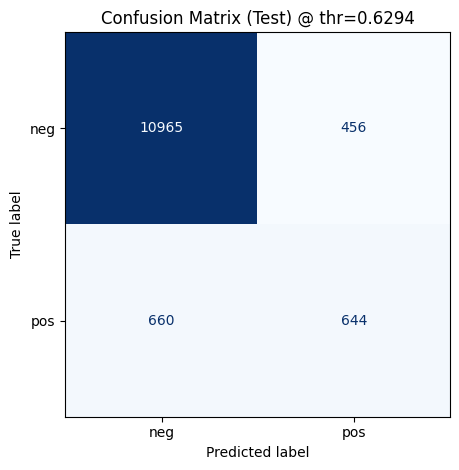

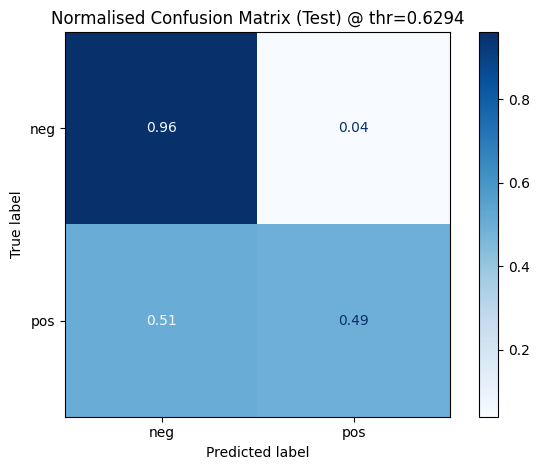

In [51]:
# Raw confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(values_format="d", cmap="Blues", colorbar=False, ax=ax)
ax.set_title(f"Confusion Matrix (Test) @ thr={thr_opt:.4f}")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "cm_test_gnn.png"), dpi=160)
plt.show()
plt.close(fig)

# Normalised confusion matrix
cm_norm = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize="true")

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=["neg", "pos"])
disp.plot(values_format=".2f", cmap="Blues", colorbar=True, ax=ax)
ax.set_title(f"Normalised Confusion Matrix (Test) @ thr={thr_opt:.4f}")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "cm_test_gnn_normalised.png"), dpi=160)
plt.show()
plt.close(fig)


## Text report

In [52]:
rep = classification_report(
    y_true,
    y_pred,
    digits=4,
    target_names=["neg", "pos"]
)

with open(os.path.join(OUT_DIR, "classification_report_test_gnn.txt"), "w") as f:
    f.write(f"Threshold used (val max-F1): {thr_opt:.6f}\n\n")
    f.write(rep)

print(rep)

              precision    recall  f1-score   support

         neg     0.9432    0.9601    0.9516     11421
         pos     0.5855    0.4939    0.5358      1304

    accuracy                         0.9123     12725
   macro avg     0.7643    0.7270    0.7437     12725
weighted avg     0.9066    0.9123    0.9090     12725



## PR Curve (Test)

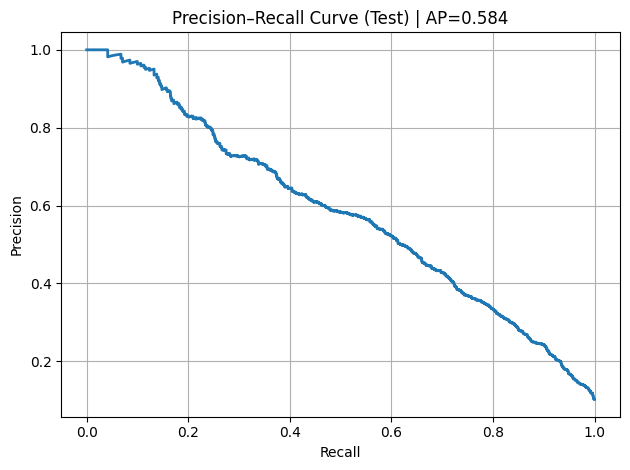

In [53]:
prec, rec, _ = precision_recall_curve(y_true, y_prob)

plt.plot(rec, prec, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (Test) | AP={average_precision_score(y_true, y_prob):.3f}")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pr_curve_test.png"), dpi=160)
plt.show()


## ROC Curve  (Test)

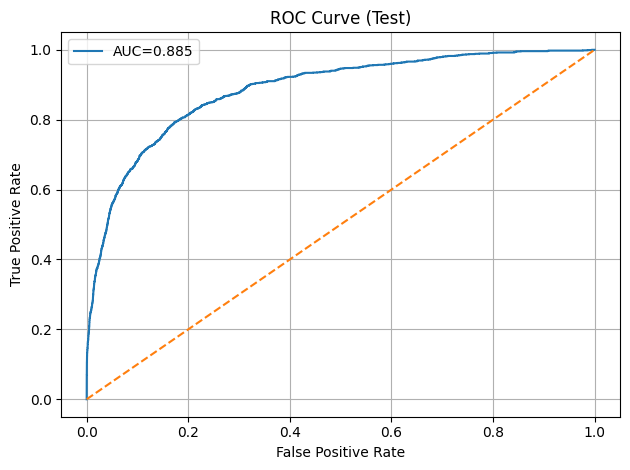

In [54]:
fpr, tpr, _ = roc_curve(y_true, y_prob)

plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_true, y_prob):.3f}")
plt.plot([0,1], [0,1], linestyle='--') # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "roc_curve_test.png"), dpi=160)
plt.show()


## Threshold–F1 Curve (Validation)

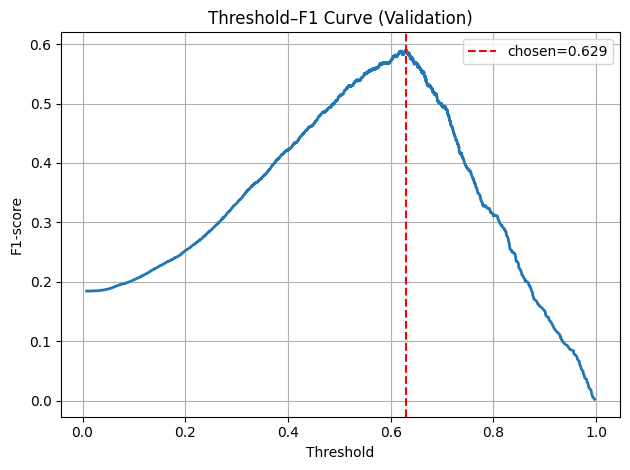

In [55]:
plt.figure()
plt.plot(thr_grid_g, f1_g, linewidth=2)
plt.axvline(thr_opt, color='red', linestyle='--', label=f"chosen={thr_opt:.3f}")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("Threshold–F1 Curve (Validation)")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(OUT_DIR, "thr_f1_curve_val_gnn.png"), dpi=160)
plt.show()

## Score Distribution Plot (Test)

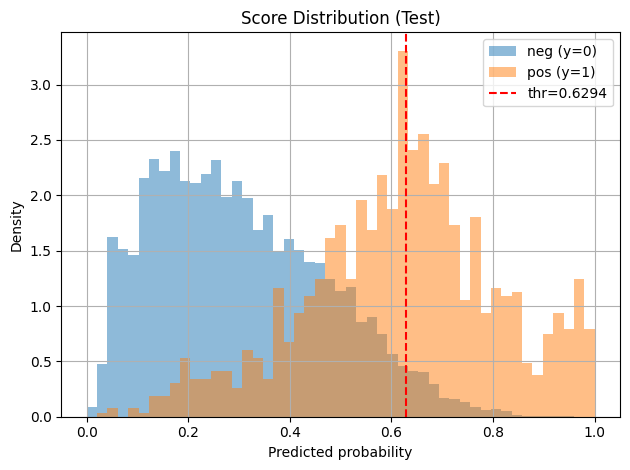

In [56]:
y_true = np.asarray(y_true)
y_prob = np.asarray(y_prob)

plt.figure()
bins = np.linspace(0, 1, 50)

# Density-based histograms
plt.hist(y_prob[y_true == 0], bins=bins, alpha=0.5, label="neg (y=0)", density=True)
plt.hist(y_prob[y_true == 1], bins=bins, alpha=0.5, label="pos (y=1)", density=True)

# Threshold line
plt.axvline(thr_opt, color='red', linestyle='--', label=f"thr={thr_opt:.4f}")

plt.xlabel("Predicted probability")
plt.ylabel("Density")
plt.title("Score Distribution (Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "score_distribution_test_gnn.png"), dpi=160)
plt.show()


## Calibration Curve + Brier Score

Brier score (Test): 0.126769


<Figure size 640x480 with 0 Axes>

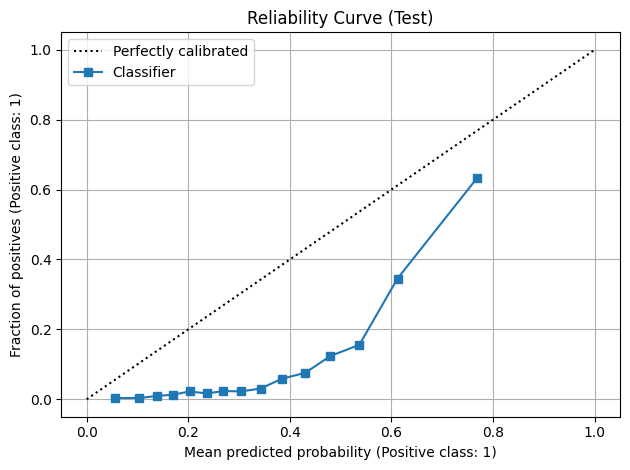

In [61]:
brier_gnn = brier_score_loss(y_true, y_prob)
print(f"Brier score (Test): {brier_gnn:.6f}")

plt.figure()
disp = CalibrationDisplay.from_predictions(
    y_true=y_true,
    y_prob=y_prob,
    n_bins=15,
    strategy="quantile"
)
plt.title("Reliability Curve (Test)")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(OUT_DIR, "calibration_curve_test_gnn.png"), dpi=160)
plt.show()

## Precision@K / Top-K Analysis

In [58]:
def precision_recall_at_k(y_true, y_score, k):
    """
    y_true: 1D array of 0/1
    y_score: 1D array of predicted probabilities
    k: int, number of top examples to take
    """
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)

    k = min(k, len(y_true))
    idx = np.argsort(y_score)[::-1][:k] # top-k scores
    topk_true = y_true[idx]

    precision = topk_true.mean()
    recall = topk_true.sum() / (y_true.sum() + 1e-12)
    return precision, recall, topk_true.sum()


def top_fraction_analysis(y_true, y_score, frac):
    """
    frac: fraction of population to flag (e.g., 0.01 for top 1%)
    """
    n = len(y_true)
    k = max(1, int(frac * n))
    return precision_recall_at_k(y_true, y_score, k)

In [59]:
Ks = [100, 500, 1000]
print("Precision@K / Recall@K on Test (GNN):")
for K in Ks:
    prec_k, rec_k, tp_k = precision_recall_at_k(y_true, y_prob, K)
    print(f"K = {K:5d} | TP in top-K = {tp_k:4d} | Precision@K = {prec_k:.4f} | Recall@K = {rec_k:.4f}")

fractions = [0.001, 0.005, 0.01]
n_test_gnn = len(y_true)
print("\nTop-fraction Analysis on Test (GNN):")
for frac in fractions:
    prec_f, rec_f, tp_f = top_fraction_analysis(y_true, y_prob, frac)
    k = max(1, int(frac * n_test_gnn))
    print(f"Top {frac*100:4.1f}% (K={k}) | TP = {tp_f:4d} | Precision = {prec_f:.4f} | Recall = {rec_f:.4f}")

Precision@K / Recall@K on Test (GNN):
K =   100 | TP in top-K =   97 | Precision@K = 0.9700 | Recall@K = 0.0744
K =   500 | TP in top-K =  367 | Precision@K = 0.7340 | Recall@K = 0.2814
K =  1000 | TP in top-K =  603 | Precision@K = 0.6030 | Recall@K = 0.4624

Top-fraction Analysis on Test (GNN):
Top  0.1% (K=12) | TP =   12 | Precision = 1.0000 | Recall = 0.0092
Top  0.5% (K=63) | TP =   62 | Precision = 0.9841 | Recall = 0.0475
Top  1.0% (K=127) | TP =  123 | Precision = 0.9685 | Recall = 0.0943


## KS Statistic + KS Plot

[GNN] KS statistic: 0.6198 at score 0.4766


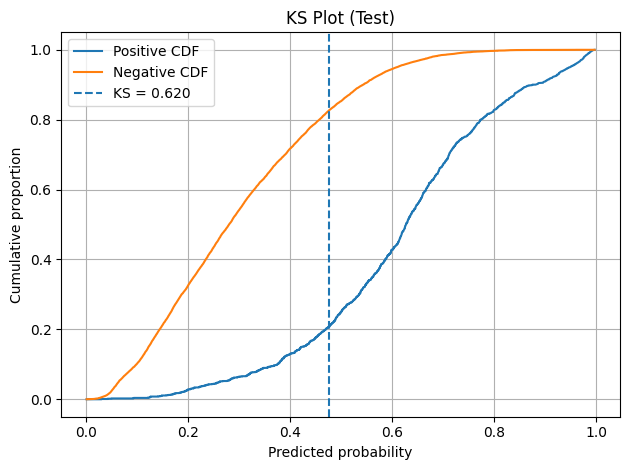

In [60]:
y_true = np.asarray(y_true, dtype=int)
y_prob = np.asarray(y_prob, dtype=float)

# sort by score
order = np.argsort(y_prob)
scores_sorted = y_prob[order]
labels_sorted = y_true[order]

# cumulative proportions
cum_pos = np.cumsum(labels_sorted) / (labels_sorted.sum() + 1e-12)
cum_neg = np.cumsum(1 - labels_sorted) / ((1 - labels_sorted).sum() + 1e-12)

ks_vals = np.abs(cum_pos - cum_neg)
ks_idx = np.argmax(ks_vals)
ks_score = scores_sorted[ks_idx]
ks_stat = ks_vals[ks_idx]

print(f"[GNN] KS statistic: {ks_stat:.4f} at score {ks_score:.4f}")

plt.figure()
plt.plot(scores_sorted, cum_pos, label="Positive CDF")
plt.plot(scores_sorted, cum_neg, label="Negative CDF")
plt.axvline(ks_score, linestyle="--", label=f"KS = {ks_stat:.3f}")
plt.xlabel("Predicted probability")
plt.ylabel("Cumulative proportion")
plt.title("KS Plot (Test)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "ks_plot_test_gnn.png"), dpi=160)
plt.show()